In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **smote + 회귀**

### smote

In [ ]:
!pip install imbalanced-learn


Class distribution before SMOTE for exp_bin:
4    12696
6    10419
3     5005
5     3086
2      451
1       12
0        3
Name: exp_bin, dtype: int64
Sampling strategy for exp_bin: {3: 9000, 5: 9000, 2: 9000, 1: 9000, 0: 9000, 4: 12696, 6: 10419}
Class distribution after SMOTE for exp_bin:
4    12696
6    10419
0     9000
1     9000
2     9000
3     9000
5     9000
Name: exp_bin, dtype: int64


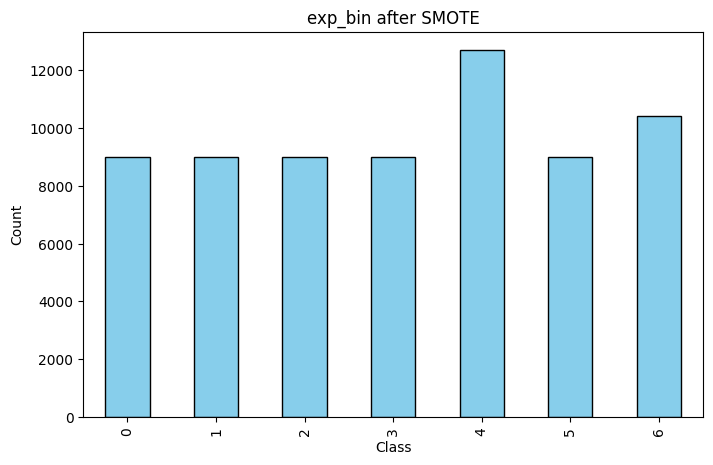

Class distribution before SMOTE for cont_bin:
4    10649
5     9555
6     8887
3     2338
2      233
1        6
0        4
Name: cont_bin, dtype: int64
Sampling strategy for cont_bin: {3: 9000, 2: 9000, 1: 9000, 0: 9000, 4: 10649, 5: 9555, 6: 8887}
Class distribution after SMOTE for cont_bin:
4    10649
5     9555
0     9000
1     9000
2     9000
3     9000
6     8887
Name: cont_bin, dtype: int64


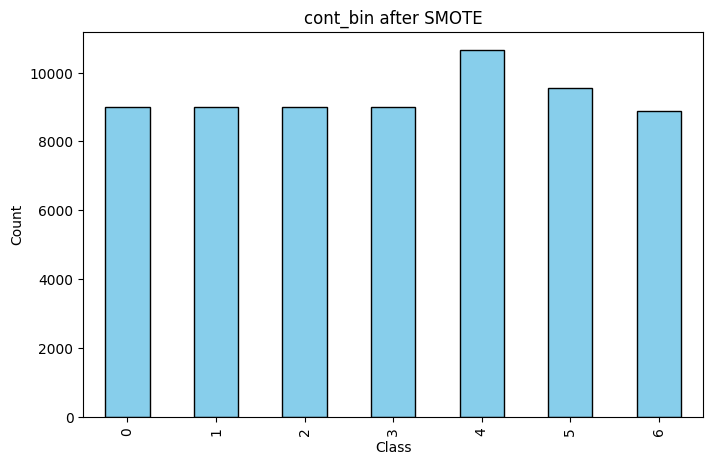

Class distribution before SMOTE for org_bin:
5    9088
6    8557
3    6656
4    5383
2    1920
1      64
0       4
Name: org_bin, dtype: int64
Sampling strategy for org_bin: {4: 8000, 2: 8000, 1: 8000, 0: 8000, 5: 9088, 6: 8557, 3: 6656}
Class distribution after SMOTE for org_bin:
5    9088
6    8557
0    8000
1    8000
2    8000
4    8000
3    6656
Name: org_bin, dtype: int64


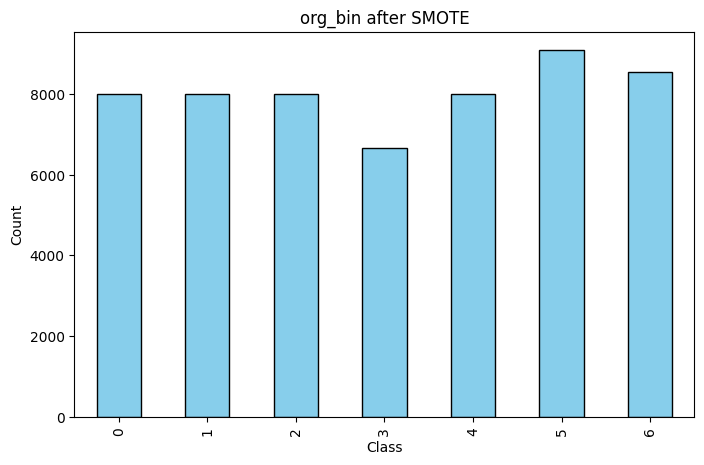

Enhanced balanced data with SMOTE has been saved to: ./final_enhanced_smote.csv


In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: CSV 파일 로드
file_path = './final.csv'
df = pd.read_csv(file_path)

# 평가 기준 열
score_columns = ['essay_scoreT_exp_avg', 'essay_scoreT_org_avg', 'essay_scoreT_cont_avg']
# 텍스트 컬럼을 동적으로 식별
text_columns = df.select_dtypes(include=['object', 'string']).columns

# 구간화 (binning) 함수
def binning(data):
    return pd.cut(data, bins=[-float('inf'), 0, 0.5, 1, 1.5, 2, 2.5, 3], labels=[0, 1, 2, 3, 4, 5, 6])

# 각 컬럼을 구간화하여 범주형 데이터로 변환
df['exp_bin'] = binning(df['essay_scoreT_exp_avg'])
df['org_bin'] = binning(df['essay_scoreT_org_avg'])
df['cont_bin'] = binning(df['essay_scoreT_cont_avg'])

# SMOTE 개선 함수
def enhanced_smote(df, target_column, focus_classes, target_size):
    X = df.drop(columns=score_columns + list(text_columns) + [target_column])
    y = df[target_column].dropna()

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 클래스별 샘플링 전략
    class_counts = y_train.value_counts()
    sampling_strategy = {cls: max(count, target_size) for cls, count in class_counts.items() if cls in focus_classes}
    for cls, count in class_counts.items():
        if cls not in focus_classes:
            sampling_strategy[cls] = count

    print(f"Class distribution before SMOTE for {target_column}:")
    print(class_counts)
    print(f"Sampling strategy for {target_column}: {sampling_strategy}")

    # SMOTE + RandomOversampling
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=1)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 클래스 분포 확인
    print(f"Class distribution after SMOTE for {target_column}:")
    print(pd.Series(y_train_balanced).value_counts())

    # 시각화
    pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', title=f"{target_column} after SMOTE", figsize=(8, 5), color='skyblue', edgecolor='black')
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

    return X_train_balanced, y_train_balanced

# 'exp_bin'에 SMOTE 적용 (적은 클래스 중심)
focus_classes_exp_bin = [0, 1, 2, 3, 5]  # 데이터가 적은 클래스
X_exp_balanced, y_exp_balanced = enhanced_smote(df, 'exp_bin', focus_classes_exp_bin, target_size=9000)
balanced_data_exp = pd.DataFrame(X_exp_balanced, columns=df.drop(columns=score_columns + list(text_columns) + ['exp_bin']).columns)
balanced_data_exp['exp_bin'] = y_exp_balanced

# 'cont_bin'에 SMOTE 적용 (적은 클래스 중심)
focus_classes_cont_bin = [0, 1, 2, 3]  # 데이터가 적은 클래스
X_cont_balanced, y_cont_balanced = enhanced_smote(df, 'cont_bin', focus_classes_cont_bin, target_size=9000)
balanced_data_cont = pd.DataFrame(X_cont_balanced, columns=df.drop(columns=score_columns + list(text_columns) + ['cont_bin']).columns)
balanced_data_cont['cont_bin'] = y_cont_balanced

# 'org_bin'에 SMOTE 적용 (적은 클래스 중심)
focus_classes_org_bin = [0, 1, 2, 4]  # 데이터가 적은 클래스
X_org_balanced, y_org_balanced = enhanced_smote(df, 'org_bin', focus_classes_org_bin, target_size=8000)
balanced_data_org = pd.DataFrame(X_org_balanced, columns=df.drop(columns=score_columns + list(text_columns) + ['org_bin']).columns)
balanced_data_org['org_bin'] = y_org_balanced

# 결과 데이터 통합
final_balanced_data = pd.concat([balanced_data_exp, balanced_data_cont[['cont_bin']], balanced_data_org[['org_bin']], df[['paragraph_txt'] + score_columns]], axis=1)

# 결과 저장
output_file_path = './final_enhanced_smote.csv'
final_balanced_data.to_csv(output_file_path, index=False)
print(f"Enhanced balanced data with SMOTE has been saved to: {output_file_path}")


### 전처리

In [ ]:
import pandas as pd

# 데이터 로드
csv_file_path = './final_enhanced_smote.csv'  # 파일 경로를 올바르게 수정
final_balanced_data = pd.read_csv(csv_file_path)

# 1. 중복된 열 제거
final_balanced_data = final_balanced_data.loc[:, ~final_balanced_data.columns.duplicated()]

# 2. 열 순서를 재정렬
column_order = [
    'paragraph_txt', 'essay_scoreT_exp_avg', 'essay_scoreT_org_avg', 'essay_scoreT_cont_avg',
    'paragraph_len', 'paragraph_id', 'essay_score_avg', 'paragraph_scoreT_avg',
    '글짓기', '대안제시', '설명글', '주장', '찬성반대',
    'org_bin', 'cont_bin', 'exp_bin'
]
final_balanced_data = final_balanced_data[column_order]

# 3. 데이터 타입 변경
final_balanced_data['org_bin'] = final_balanced_data['org_bin'].astype('category')
final_balanced_data['cont_bin'] = final_balanced_data['cont_bin'].astype('category')
final_balanced_data['exp_bin'] = final_balanced_data['exp_bin'].astype('float64')

# 4. 결과 확인
print(final_balanced_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68115 entries, 0 to 68114
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   paragraph_txt          39591 non-null  object  
 1   essay_scoreT_exp_avg   39591 non-null  float64 
 2   essay_scoreT_org_avg   39591 non-null  float64 
 3   essay_scoreT_cont_avg  39591 non-null  float64 
 4   paragraph_len          68115 non-null  int64   
 5   paragraph_id           68115 non-null  int64   
 6   essay_score_avg        68115 non-null  float64 
 7   paragraph_scoreT_avg   68115 non-null  float64 
 8   글짓기                    68115 non-null  int64   
 9   대안제시                   68115 non-null  int64   
 10  설명글                    68115 non-null  int64   
 11  주장                     68115 non-null  int64   
 12  찬성반대                   68115 non-null  int64   
 13  org_bin                59115 non-null  category
 14  cont_bin               55506 non-null 

<ipython-input-3-1582bc1dc19d>:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  final_balanced_data = pd.read_csv(csv_file_path)


In [ ]:
# 1. org_bin와 cont_bin에 exp_bin 크기에 맞춰 랜덤 샘플링으로 데이터 추가
def sample_and_expand(column, target_size):
    existing_data = final_balanced_data[column].dropna()
    sampled_data = np.random.choice(existing_data, size=target_size, replace=True)
    return sampled_data

# exp_bin 크기에 맞춰 org_bin와 cont_bin 확장
final_balanced_data['org_bin'] = sample_and_expand('org_bin', len(final_balanced_data))
final_balanced_data['cont_bin'] = sample_and_expand('cont_bin', len(final_balanced_data))

# 2. paragraph_txt 결측값 채우기
# 기존 데이터에서 paragraph_txt의 결측값이 없는 데이터를 가져오기
existing_paragraph_txt = final_balanced_data['paragraph_txt'].dropna()

In [ ]:
import pandas as pd

def fill_paragraph_txt_nan(row, lookup_data):
    """
    org_bin, cont_bin, exp_bin가 모두 일치하는 경우 paragraph_txt를 가져옴.
    """
    if pd.isna(row['paragraph_txt']):
        matching_row = lookup_data[
            (lookup_data['org_bin'] == row['org_bin']) &
            (lookup_data['cont_bin'] == row['cont_bin']) &
            (lookup_data['exp_bin'] == row['exp_bin'])
        ]
        if not matching_row.empty:
            return matching_row['paragraph_txt'].iloc[0]
    return row['paragraph_txt']

def fill_paragraph_txt_nan_with_two_matches(row, lookup_data):
    """
    org_bin, cont_bin, exp_bin 중 두 개가 일치하는 경우 paragraph_txt를 가져옴.
    """
    if pd.isna(row['paragraph_txt']):
        # org_bin, cont_bin 일치
        matching_rows = lookup_data[
            (lookup_data['org_bin'] == row['org_bin']) &
            (lookup_data['cont_bin'] == row['cont_bin'])
        ]
        if not matching_rows.empty:
            return matching_rows['paragraph_txt'].iloc[0]

        # org_bin, exp_bin 일치
        matching_rows = lookup_data[
            (lookup_data['org_bin'] == row['org_bin']) &
            (lookup_data['exp_bin'] == row['exp_bin'])
        ]
        if not matching_rows.empty:
            return matching_rows['paragraph_txt'].iloc[0]

        # cont_bin, exp_bin 일치
        matching_rows = lookup_data[
            (lookup_data['cont_bin'] == row['cont_bin']) &
            (lookup_data['exp_bin'] == row['exp_bin'])
        ]
        if not matching_rows.empty:
            return matching_rows['paragraph_txt'].iloc[0]
    return row['paragraph_txt']

# 39591 이전 데이터에서 lookup 테이블 생성
lookup_data = final_balanced_data.loc[:39590].dropna(subset=['paragraph_txt'])

# Step 1: 모든 조건 (org_bin, cont_bin, exp_bin) 일치
final_balanced_data['paragraph_txt'] = final_balanced_data.apply(
    lambda row: fill_paragraph_txt_nan(row, lookup_data), axis=1
)

# Step 2: 두 조건이 일치하는 경우 (org_bin-cont_bin, org_bin-exp_bin, cont_bin-exp_bin)
final_balanced_data['paragraph_txt'] = final_balanced_data.apply(
    lambda row: fill_paragraph_txt_nan_with_two_matches(row, lookup_data), axis=1
)


In [ ]:
import numpy as np

# `bin` 값에 따라 범위를 반환하는 함수
def get_range_from_bin(bin_value):
    bin_ranges = {
        0: (0, 0.5),
        1: (0.5, 1),
        2: (1, 1.5),
        3: (1.5, 2),
        4: (2, 2.5),
        5: (2.5, 3),
        6: (3, 3)  # 고정값
    }
    return bin_ranges[int(bin_value)]

# 각 bin별 데이터를 생성하는 함수
def generate_values_by_bin(df, bin_column, target_column, start_index):
    # 39591 이후 데이터만 처리
    for bin_value in sorted(df.loc[start_index:, bin_column].unique()):
        bin_mask = (df.index >= start_index) & (df[bin_column] == bin_value) & (df[target_column].isna())
        bin_count = bin_mask.sum()  # 해당 bin의 결측 데이터 개수
        lower, upper = get_range_from_bin(bin_value)  # 범위 가져오기

        # 해당 bin의 결측값에 대해 랜덤 값 생성
        df.loc[bin_mask, target_column] = np.round(
            np.random.uniform(lower, upper, size=bin_count), 4
        )
    return df

# 39591 이후 데이터의 결측값만 처리
start_index = 39591
columns_to_round = ['essay_scoreT_exp_avg', 'essay_scoreT_cont_avg', 'essay_scoreT_org_avg']

# 결측값 생성
final_balanced_data = generate_values_by_bin(final_balanced_data, bin_column="exp_bin", target_column="essay_scoreT_exp_avg", start_index=start_index)
final_balanced_data = generate_values_by_bin(final_balanced_data, bin_column="cont_bin", target_column="essay_scoreT_cont_avg", start_index=start_index)
final_balanced_data = generate_values_by_bin(final_balanced_data, bin_column="org_bin", target_column="essay_scoreT_org_avg", start_index=start_index)

# 0보다 작거나 3보다 큰 값 제거 (안전한 값 범위 보장)
for col in columns_to_round:
    final_balanced_data[col] = final_balanced_data[col].clip(lower=0, upper=3)

# 데이터프레임을 CSV 파일로 저장
output_file_path = "1120.csv"
final_balanced_data.to_csv(output_file_path, index=False, encoding='utf-8-sig')

print(f"결과가 {output_file_path}에 저장되었습니다.")


결과가 1120.csv에 저장되었습니다.


### 모델 고도화

In [5]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# CSV 파일 경로
file_path = '/content/drive/MyDrive/BITAmin/24년 2학기/2학기 프로젝트/nlp_final.csv'
df = pd.read_csv(file_path)

# 평가 기준 열
score_columns = ['essay_scoreT_exp_avg', 'essay_scoreT_org_avg', 'essay_scoreT_cont_avg']

# 학습 데이터와 테스트 데이터 분리
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['paragraph_txt'], df[score_columns], test_size=0.2, random_state=42
)

# GPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 토크나이저 및 인코딩 설정
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# 데이터셋 정의
class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EssayDataset(train_encodings, train_labels.values.tolist())
test_dataset = EssayDataset(test_encodings, test_labels.values.tolist())

# 데이터 패딩을 위한 Collator 추가
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 회귀 작업을 위한 모델 설정
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", num_labels=3
)
model.to(device)  # 모델을 GPU로 이동

# 맞춤형 Trainer 설정 (회귀 작업에 적합한 MSE 계산을 위해)
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):

        labels = inputs.get("labels").to(model.device)  # Ensure labels are on the same device as the model
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = F.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,  # Epoch 수 감소
    per_device_train_batch_size=32,  # 배치 크기 증가
    per_device_eval_batch_size=32,  # 평가 배치 크기 증가
    warmup_steps=200,  # 워밍업 단계 추가
    learning_rate=3e-5,  # 학습률 조정
    weight_decay=0.01,  # 가중치 감소
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    gradient_accumulation_steps=2,  # 그래디언트 누적
    fp16=True,  # 혼합 정밀도 학습
    dataloader_num_workers=4,  # 데이터 로드 워커 수 증가
)

# Trainer 설정 및 학습
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,  # 데이터 패딩 처리
)

# 모델 학습
trainer.train()

# 모델 저장
model_save_path = '/content/drive/MyDrive/BITAmin/24년 2학기/2학기 프로젝트/saved_model3'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

# 테스트 데이터셋으로 모델 평가
test_preds = trainer.predict(test_dataset)
test_mse = mean_squared_error(test_labels, test_preds.predictions)
print(f"Test MSE: {test_mse}")


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
0,0.546900,0.095303
2,0.072100,0.080774
3,0.064500,0.077739


Test MSE: 0.077738836381142


### 피드백

In [7]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# CSV 파일 경로
file_path = '/content/drive/MyDrive/BITAmin/24년 2학기/2학기 프로젝트/nlp_final.csv'
df = pd.read_csv(file_path)

# GPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 토크나이저 및 모델 설정
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model_save_path = '/content/drive/MyDrive/BITAmin/24년 2학기/2학기 프로젝트/saved_model3'
model = BertForSequenceClassification.from_pretrained(model_save_path)
model.to(device)  # 모델을 GPU로 이동

# 예측 생성 및 피드백 함수
def predict_feedback(paragraph):
    # 토큰화 및 텐서 변환
    inputs = tokenizer(paragraph, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # 입력 텐서를 GPU로 이동

    # 모델 예측
    model.eval()  # 평가 모드로 전환
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits[0].cpu().numpy()  # GPU에서 CPU로 이동 후 Numpy 배열로 변환

    # 피드백 생성
    feedback = generate_feedback(scores[0], scores[1], scores[2])
    return scores, feedback

# 피드백 생성 함수
def generate_feedback(expression_score, organization_score, content_score):
    feedback = ""

    # 표현 피드백
    if expression_score >= 2.66:
        feedback += "표현력이 뛰어나고 다양한 어휘와 적절한 표현을 사용하여 내용을 잘 전달하고 있습니다.\n"
    elif expression_score >= 1.67:
        feedback += "표현이 적절하나, 일부 문장에서 좀 더 자연스러운 표현을 사용하면 좋을 것 같습니다.\n"
    else:
        feedback += "표현력이 부족합니다. 다양한 어휘와 표현 연습을 통해 전달력을 높이는 것이 필요합니다.\n"

    # 구성 피드백
    if organization_score >= 2.68:
        feedback += "구성이 매우 체계적이고 읽기 쉽게 잘 작성되었습니다.\n"
    elif organization_score >= 1.72:
        feedback += "구성이 적절하지만, 문단 간 연결이 매끄럽지 않은 부분이 있습니다.\n"
    else:
        feedback += "구성이 약하고 글의 흐름이 자연스럽지 않습니다. 글의 구조화와 연결성을 강화해 보세요.\n"

    # 내용 피드백
    if content_score >= 2.65:
        feedback += "내용이 충실하며 주제에 대한 이해도가 높음을 보여줍니다.\n"
    elif content_score >= 1.71:
        feedback += "내용이 적절하나 일부 핵심 아이디어나 구체적인 예시가 부족할 수 있습니다.\n"
    else:
        feedback += "내용이 부족하며, 추가적인 설명과 구체적인 예시가 필요합니다.\n"

    return feedback

# 예시 문장
example_paragraph = """
저는 밥 먹었다. 그리고 뛰는 했다. 그리고 공부를 하였다요. 그래서 오늘 하루가 되었다.
"""

# 예측 및 피드백 생성
scores, feedback = predict_feedback(example_paragraph)

# 결과 출력
print(f"예측된 점수:\n표현: {scores[0]:.2f}, 구성: {scores[1]:.2f}, 내용: {scores[2]:.2f}")
print(f"피드백:\n{feedback}")


Using device: cuda
예측된 점수:
표현: 1.74, 구성: 1.32, 내용: 1.55
피드백:
표현이 적절하나, 일부 문장에서 좀 더 자연스러운 표현을 사용하면 좋을 것 같습니다.
구성이 약하고 글의 흐름이 자연스럽지 않습니다. 글의 구조화와 연결성을 강화해 보세요.
내용이 부족하며, 추가적인 설명과 구체적인 예시가 필요합니다.



In [8]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# CSV 파일 경로
file_path = '/content/drive/MyDrive/BITAmin/24년 2학기/2학기 프로젝트/nlp_final.csv'
df = pd.read_csv(file_path)

# GPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 토크나이저 및 모델 설정
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model_save_path = '/content/drive/MyDrive/BITAmin/24년 2학기/2학기 프로젝트/saved_model3'
model = BertForSequenceClassification.from_pretrained(model_save_path)
model.to(device)  # 모델을 GPU로 이동

# 예측 생성 및 피드백 함수
def predict_feedback(paragraph):
    # 토큰화 및 텐서 변환
    inputs = tokenizer(paragraph, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # 입력 텐서를 GPU로 이동

    # 모델 예측
    model.eval()  # 평가 모드로 전환
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits[0].cpu().numpy()  # GPU에서 CPU로 이동 후 Numpy 배열로 변환

    # 피드백 생성
    feedback = generate_feedback(scores[0], scores[1], scores[2])
    return scores, feedback

# 피드백 생성 함수
def generate_feedback(expression_score, organization_score, content_score):
    feedback = ""

    # 표현 피드백
    if expression_score >= 2.66:
        feedback += "표현력이 뛰어나고 다양한 어휘와 적절한 표현을 사용하여 내용을 잘 전달하고 있습니다.\n"
    elif expression_score >= 1.67:
        feedback += "표현이 적절하나, 일부 문장에서 좀 더 자연스러운 표현을 사용하면 좋을 것 같습니다.\n"
    else:
        feedback += "표현력이 부족합니다. 다양한 어휘와 표현 연습을 통해 전달력을 높이는 것이 필요합니다.\n"

    # 구성 피드백
    if organization_score >= 2.68:
        feedback += "구성이 매우 체계적이고 읽기 쉽게 잘 작성되었습니다.\n"
    elif organization_score >= 1.72:
        feedback += "구성이 적절하지만, 문단 간 연결이 매끄럽지 않은 부분이 있습니다.\n"
    else:
        feedback += "구성이 약하고 글의 흐름이 자연스럽지 않습니다. 글의 구조화와 연결성을 강화해 보세요.\n"

    # 내용 피드백
    if content_score >= 2.65:
        feedback += "내용이 충실하며 주제에 대한 이해도가 높음을 보여줍니다.\n"
    elif content_score >= 1.71:
        feedback += "내용이 적절하나 일부 핵심 아이디어나 구체적인 예시가 부족할 수 있습니다.\n"
    else:
        feedback += "내용이 부족하며, 추가적인 설명과 구체적인 예시가 필요합니다.\n"

    return feedback

# 예시 문장들
example_paragraphs = [
    """
    나는 오늘 학교에 갔습니다. 학교는 참 좋았습니다. 선생님도 좋았습니다. 나는 학교에서 공부했습니다. 점심을 먹고 집에 갔습니다. 그래서 오늘은 학교에 갔다가 집에 갔습니다.
    """,
    """
    어제는 날씨가 좋았습니다. 그래서 공원에 갔습니다. 공원에 갔는데 강아지를 만났습니다. 그 강아지는 귀엽고 작았습니다. 저는 공원에서 음료수를 마셨습니다. 날씨가 좋아서 공원에 있었습니다.
    """,
    """
    이 영화는 재미있었습니다. 영화는 주제가 좋았습니다. 주인공이 잘 싸웠습니다. 영화의 마지막이 좋았습니다. 영화관이 좋아서 영화가 재미있었습니다.
    """,
    """
    제가 이 회사에 지원한 이유는 이 회사가 저한테 맞는 회사라고 생각했기 때문입니다. 그래서 저는 이 회사에 지원하게 됐습니다. 그래서 이 회사에서 일하면 저의 실력이 늘어날 수 있고, 이 회사에서 제공하는 다양한 기회들이 저에게 도움이 될 거라고 생각했습니다. 그래서 이 회사에 지원을 하게 되었습니다. 저는 이 회사에서 일하고 싶고, 이 회사의 좋은 점이 많아서 지원하게 되었습니다.
    """
]

# 모든 문장을 평가
for idx, paragraph in enumerate(example_paragraphs, 1):
    print(f"=== 예시 문장 {idx} ===")
    scores, feedback = predict_feedback(paragraph)
    print(f"예측된 점수:\n표현: {scores[0]:.2f}, 구성: {scores[1]:.2f}, 내용: {scores[2]:.2f}")
    print(f"피드백:\n{feedback}")
    print("\n")


Using device: cuda
=== 예시 문장 1 ===
예측된 점수:
표현: 1.53, 구성: 1.22, 내용: 1.76
피드백:
표현력이 부족합니다. 다양한 어휘와 표현 연습을 통해 전달력을 높이는 것이 필요합니다.
구성이 약하고 글의 흐름이 자연스럽지 않습니다. 글의 구조화와 연결성을 강화해 보세요.
내용이 적절하나 일부 핵심 아이디어나 구체적인 예시가 부족할 수 있습니다.



=== 예시 문장 2 ===
예측된 점수:
표현: 2.11, 구성: 1.82, 내용: 1.99
피드백:
표현이 적절하나, 일부 문장에서 좀 더 자연스러운 표현을 사용하면 좋을 것 같습니다.
구성이 적절하지만, 문단 간 연결이 매끄럽지 않은 부분이 있습니다.
내용이 적절하나 일부 핵심 아이디어나 구체적인 예시가 부족할 수 있습니다.



=== 예시 문장 3 ===
예측된 점수:
표현: 2.00, 구성: 2.07, 내용: 1.36
피드백:
표현이 적절하나, 일부 문장에서 좀 더 자연스러운 표현을 사용하면 좋을 것 같습니다.
구성이 적절하지만, 문단 간 연결이 매끄럽지 않은 부분이 있습니다.
내용이 부족하며, 추가적인 설명과 구체적인 예시가 필요합니다.



=== 예시 문장 4 ===
예측된 점수:
표현: 2.14, 구성: 2.74, 내용: 2.51
피드백:
표현이 적절하나, 일부 문장에서 좀 더 자연스러운 표현을 사용하면 좋을 것 같습니다.
구성이 매우 체계적이고 읽기 쉽게 잘 작성되었습니다.
내용이 적절하나 일부 핵심 아이디어나 구체적인 예시가 부족할 수 있습니다.



